Example taken from https://pystruct.github.io/auto_examples/plot_snakes.html#sphx-glr-auto-examples-plot-snakes-py

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix, accuracy_score

from pystruct.learners import OneSlackSSVM
from pystruct.datasets import load_snakes
from pystruct.utils import make_grid_edges, edge_list_to_features
from pystruct.models import EdgeFeatureGraphCRF

def one_hot_colors(x):
    x = x / 255
    flat = np.dot(x.reshape(-1, 3), 2 ** np.arange(3))
    one_hot = label_binarize(flat, classes=[1, 2, 3, 4, 6])
    return one_hot.reshape(x.shape[0], x.shape[1], 5)


def neighborhood_feature(x):
    """Add a 3x3 neighborhood around each pixel as a feature."""
    # we could also use a four neighborhood, that would work even better
    # but one might argue then we are using domain knowledge ;)
    features = np.zeros((x.shape[0], x.shape[1], 5, 9))
    # position 3 is background.
    features[:, :, 3, :] = 1
    features[1:, 1:, :, 0] = x[:-1, :-1, :]
    features[:, 1:, :, 1] = x[:, :-1, :]
    features[:-1, 1:, :, 2] = x[1:, :-1, :]
    features[1:, :, :, 3] = x[:-1, :, :]
    features[:-1, :-1, :, 4] = x[1:, 1:, :]
    features[:-1, :, :, 5] = x[1:, :, :]
    features[1:, :-1, :, 6] = x[:-1, 1:, :]
    features[:, :-1, :, 7] = x[:, 1:, :]
    features[:, :, :, 8] = x[:, :, :]
    return features.reshape(x.shape[0] * x.shape[1], -1)


def prepare_data(X):
    X_directions = []
    X_edge_features = []
    for x in X:
        # get edges in grid
        right, down = make_grid_edges(x, return_lists=True)
        edges = np.vstack([right, down])
        # use 3x3 patch around each point
        features = neighborhood_feature(x)
        # simple edge feature that encodes just if an edge is horizontal or
        # vertical
        edge_features_directions = edge_list_to_features([right, down])
        # edge feature that contains features from the nodes that the edge connects
        edge_features = np.zeros((edges.shape[0], features.shape[1], 2))
        edge_features[:len(right), :, 0] = features[right[:, 0]]
        edge_features[:len(right), :, 1] = features[right[:, 1]]
        edge_features[len(right):, :, 0] = features[down[:, 0]]
        edge_features[len(right):, :, 1] = features[down[:, 1]]
        edge_features = edge_features.reshape(edges.shape[0], -1)
        X_directions.append((features, edges, edge_features_directions))
        X_edge_features.append((features, edges, edge_features))
    return X_directions, X_edge_features


print("Please be patient. Learning will take 5-20 minutes.")
snakes = load_snakes()
X_train, Y_train = snakes['X_train'], snakes['Y_train']

X_train = [one_hot_colors(x) for x in X_train]
Y_train_flat = [y_.ravel() for y_ in Y_train]

X_train_directions, X_train_edge_features = prepare_data(X_train)

inference = 'qpbo'

X_test, Y_test = snakes['X_test'], snakes['Y_test']
X_test = [one_hot_colors(x) for x in X_test]
Y_test_flat = [y_.ravel() for y_ in Y_test]
X_test_directions, X_test_edge_features = prepare_data(X_test)

Please be patient. Learning will take 5-20 minutes.


The training data contains 200 examples of different snake grids. The dimension of each example is (7, 6, 5), which corresponds to a 7x6 board such that each square has five states (up, down, left, right, blank). Blank indicates that the snake was not present on the square.

In [11]:
print("Number of training examples: ", len(X_train))
print("Dimensions of training example: ", X_train[0].shape)

Number of training examples:  200
Dimensions of training example:  (7, 6, 5)


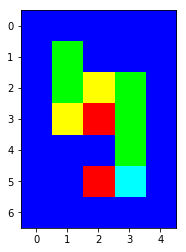

In [17]:
plt.imshow(snakes['X_test'][0], interpolation='nearest')

The image above repesents one of the grids in the test set. The color key is We code the five different input colors (for up, down, left, right, background) using a one-hot encoding.

In [9]:
X_train[0][0]

array([[0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0]])

In [7]:
np.array(X_train_edge_features).shape

(200, 3)

In [4]:
len(Y_train_flat)

200

In [5]:
X_train_directions[0][0][0, :]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 1., 1., 0., 1., 1.,
       1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [6]:
X_train_directions[0][1]

array([[ 0,  1],
       [ 1,  2],
       [ 2,  3],
       [ 3,  4],
       [ 4,  5],
       [ 6,  7],
       [ 7,  8],
       [ 8,  9],
       [ 9, 10],
       [10, 11],
       [12, 13],
       [13, 14],
       [14, 15],
       [15, 16],
       [16, 17],
       [18, 19],
       [19, 20],
       [20, 21],
       [21, 22],
       [22, 23],
       [24, 25],
       [25, 26],
       [26, 27],
       [27, 28],
       [28, 29],
       [30, 31],
       [31, 32],
       [32, 33],
       [33, 34],
       [34, 35],
       [36, 37],
       [37, 38],
       [38, 39],
       [39, 40],
       [40, 41],
       [ 0,  6],
       [ 1,  7],
       [ 2,  8],
       [ 3,  9],
       [ 4, 10],
       [ 5, 11],
       [ 6, 12],
       [ 7, 13],
       [ 8, 14],
       [ 9, 15],
       [10, 16],
       [11, 17],
       [12, 18],
       [13, 19],
       [14, 20],
       [15, 21],
       [16, 22],
       [17, 23],
       [18, 24],
       [19, 25],
       [20, 26],
       [21, 27],
       [22, 28],
       [23, 29

In [7]:
Y_train[0].shape

(7, 6)

In [8]:
Y_train_flat[0]

array([ 0,  0,  0,  0,  0,  0,  0,  2,  3,  0,  0,  0,  0,  1,  4,  5,  0,
        0,  0,  0,  0,  6,  7,  0,  0,  0,  0,  9,  8,  0,  0,  0,  0, 10,
        0,  0,  0,  0,  0,  0,  0,  0], dtype=uint8)

In [9]:
Y_train[0]

array([[ 0,  0,  0,  0,  0,  0],
       [ 0,  2,  3,  0,  0,  0],
       [ 0,  1,  4,  5,  0,  0],
       [ 0,  0,  0,  6,  7,  0],
       [ 0,  0,  0,  9,  8,  0],
       [ 0,  0,  0, 10,  0,  0],
       [ 0,  0,  0,  0,  0,  0]], dtype=uint8)

In [10]:
X_train[0].shape

(7, 6, 5)

In [11]:
X_train[0]

array([[[0, 0, 0, 1, 0],
        [0, 0, 0, 1, 0],
        [0, 0, 0, 1, 0],
        [0, 0, 0, 1, 0],
        [0, 0, 0, 1, 0],
        [0, 0, 0, 1, 0]],

       [[0, 0, 0, 1, 0],
        [0, 0, 1, 0, 0],
        [0, 1, 0, 0, 0],
        [0, 0, 0, 1, 0],
        [0, 0, 0, 1, 0],
        [0, 0, 0, 1, 0]],

       [[0, 0, 0, 1, 0],
        [1, 0, 0, 0, 0],
        [0, 0, 1, 0, 0],
        [0, 1, 0, 0, 0],
        [0, 0, 0, 1, 0],
        [0, 0, 0, 1, 0]],

       [[0, 0, 0, 1, 0],
        [0, 0, 0, 1, 0],
        [0, 0, 0, 1, 0],
        [0, 0, 1, 0, 0],
        [0, 1, 0, 0, 0],
        [0, 0, 0, 1, 0]],

       [[0, 0, 0, 1, 0],
        [0, 0, 0, 1, 0],
        [0, 0, 0, 1, 0],
        [0, 1, 0, 0, 0],
        [0, 0, 0, 0, 1],
        [0, 0, 0, 1, 0]],

       [[0, 0, 0, 1, 0],
        [0, 0, 0, 1, 0],
        [0, 0, 0, 1, 0],
        [0, 1, 0, 0, 0],
        [0, 0, 0, 1, 0],
        [0, 0, 0, 1, 0]],

       [[0, 0, 0, 1, 0],
        [0, 0, 0, 1, 0],
        [0, 0, 0, 1, 0],
        [0, 0

In [12]:
X_train[0].shape

(7, 6, 5)

In [13]:
Y_train[0].shape

(7, 6)

In [14]:
X_train[0][0, 0]

array([0, 0, 0, 1, 0])

In [15]:
X_train_directions[0][0].shape

(42, 45)

In [16]:
X_train_edge_features[0][0].shape

(42, 45)

In [17]:
X_train_edge_features[0][1].shape

(71, 2)

In [18]:
X_train_directions[0][2]

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.

In [19]:
X_train_edge_features[0][2].shape

(71, 90)

In [20]:
Y_train[0][1, 1]

2

In [21]:
Y_train[0]

array([[ 0,  0,  0,  0,  0,  0],
       [ 0,  2,  3,  0,  0,  0],
       [ 0,  1,  4,  5,  0,  0],
       [ 0,  0,  0,  6,  7,  0],
       [ 0,  0,  0,  9,  8,  0],
       [ 0,  0,  0, 10,  0,  0],
       [ 0,  0,  0,  0,  0,  0]], dtype=uint8)

In [22]:
180/45

4.0

In [23]:
right, down = make_grid_edges(X_train[0], return_lists=True)

In [24]:
neighborhood_feature(X_train[0]).shape

(42, 45)

In [25]:
X_train[0]

array([[[0, 0, 0, 1, 0],
        [0, 0, 0, 1, 0],
        [0, 0, 0, 1, 0],
        [0, 0, 0, 1, 0],
        [0, 0, 0, 1, 0],
        [0, 0, 0, 1, 0]],

       [[0, 0, 0, 1, 0],
        [0, 0, 1, 0, 0],
        [0, 1, 0, 0, 0],
        [0, 0, 0, 1, 0],
        [0, 0, 0, 1, 0],
        [0, 0, 0, 1, 0]],

       [[0, 0, 0, 1, 0],
        [1, 0, 0, 0, 0],
        [0, 0, 1, 0, 0],
        [0, 1, 0, 0, 0],
        [0, 0, 0, 1, 0],
        [0, 0, 0, 1, 0]],

       [[0, 0, 0, 1, 0],
        [0, 0, 0, 1, 0],
        [0, 0, 0, 1, 0],
        [0, 0, 1, 0, 0],
        [0, 1, 0, 0, 0],
        [0, 0, 0, 1, 0]],

       [[0, 0, 0, 1, 0],
        [0, 0, 0, 1, 0],
        [0, 0, 0, 1, 0],
        [0, 1, 0, 0, 0],
        [0, 0, 0, 0, 1],
        [0, 0, 0, 1, 0]],

       [[0, 0, 0, 1, 0],
        [0, 0, 0, 1, 0],
        [0, 0, 0, 1, 0],
        [0, 1, 0, 0, 0],
        [0, 0, 0, 1, 0],
        [0, 0, 0, 1, 0]],

       [[0, 0, 0, 1, 0],
        [0, 0, 0, 1, 0],
        [0, 0, 0, 1, 0],
        [0, 0

In [26]:
right

array([[ 0,  1],
       [ 1,  2],
       [ 2,  3],
       [ 3,  4],
       [ 4,  5],
       [ 6,  7],
       [ 7,  8],
       [ 8,  9],
       [ 9, 10],
       [10, 11],
       [12, 13],
       [13, 14],
       [14, 15],
       [15, 16],
       [16, 17],
       [18, 19],
       [19, 20],
       [20, 21],
       [21, 22],
       [22, 23],
       [24, 25],
       [25, 26],
       [26, 27],
       [27, 28],
       [28, 29],
       [30, 31],
       [31, 32],
       [32, 33],
       [33, 34],
       [34, 35],
       [36, 37],
       [37, 38],
       [38, 39],
       [39, 40],
       [40, 41]])

In [27]:
edges = np.vstack([right, down])

In [28]:
edges.shape

(71, 2)

In [29]:
X_train_edge_features[0][2].shape

(71, 90)

In [30]:
X_train_edge_features[0][2][0,:]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 0., 1., 1.,
       1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.])

In [34]:
Y_train[0].ravel().shape

(42,)

In [36]:
np.hstack([y.ravel() for y in Y_train])

array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)

In [ ]:
len(np.unique(np.hstack([y.ravel() for y in Y])))

Results using only directional features for edges
Test accuracy: 0.829
[[2750    0    0    0    0    0    0    0    0    0    0]
 [   0   98    0    0    1    0    0    0    1    0    0]
 [   0    6   38    3   34    8    1    2    5    1    2]
 [   0    9    8   10    8   41    1   12    3    7    1]
 [   0    1   14    2   37    8    1    9   21    5    2]
 [   0    4    2    9   16   29    2   19   11    7    1]
 [   0    2   13    3   30   16    2    7   20    5    2]
 [   0    7    5    8   15   29    3   14    8   11    0]
 [   0    3   10    3   29   10    1    6   20    3   15]
 [   0    9    3    2   10    8    0   15    4   46    3]
 [   0    2    7    3    9    1    1    3    7    3   64]]
Results using also input features for edges
Test accuracy: 0.998
[[2749    0    0    0    0    0    0    0    1    0    0]
 [   0  100    0    0    0    0    0    0    0    0    0]
 [   0    0  100    0    0    0    0    0    0    0    0]
 [   0    0    0  100    0    0    0    0    0    0

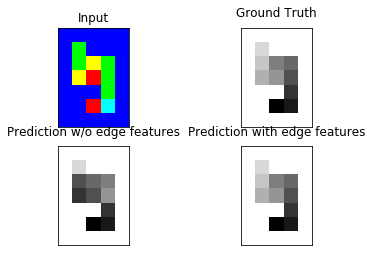

In [14]:
inference = 'qpbo'
# first, train on X with directions only:
crf = EdgeFeatureGraphCRF(inference_method=inference)
ssvm = OneSlackSSVM(crf, inference_cache=50, C=.1, tol=.1, max_iter=100,
                    n_jobs=1)
ssvm.fit(X_train_directions, Y_train_flat)

# Evaluate using confusion matrix.
# Clearly the middel of the snake is the hardest part.
X_test, Y_test = snakes['X_test'], snakes['Y_test']
X_test = [one_hot_colors(x) for x in X_test]
Y_test_flat = [y_.ravel() for y_ in Y_test]
X_test_directions, X_test_edge_features = prepare_data(X_test)
Y_pred = ssvm.predict(X_test_directions)
print("Results using only directional features for edges")
print("Test accuracy: %.3f"
      % accuracy_score(np.hstack(Y_test_flat), np.hstack(Y_pred)))
print(confusion_matrix(np.hstack(Y_test_flat), np.hstack(Y_pred)))

# now, use more informative edge features:
crf = EdgeFeatureGraphCRF(inference_method=inference)
ssvm = OneSlackSSVM(crf, inference_cache=50, C=.1, tol=.1, switch_to='ad3',
                    n_jobs=-1)
ssvm.fit(X_train_edge_features, Y_train_flat)
Y_pred2 = ssvm.predict(X_test_edge_features)
print("Results using also input features for edges")
print("Test accuracy: %.3f"
      % accuracy_score(np.hstack(Y_test_flat), np.hstack(Y_pred2)))
print(confusion_matrix(np.hstack(Y_test_flat), np.hstack(Y_pred2)))

# plot stuff
fig, axes = plt.subplots(2, 2)
axes[0, 0].imshow(snakes['X_test'][0], interpolation='nearest')
axes[0, 0].set_title('Input')
y = Y_test[0].astype(np.int)
bg = 2 * (y != 0)  # enhance contrast
axes[0, 1].matshow(y + bg, cmap=plt.cm.Greys)
axes[0, 1].set_title("Ground Truth")
axes[1, 0].matshow(Y_pred[0].reshape(y.shape) + bg, cmap=plt.cm.Greys)
axes[1, 0].set_title("Prediction w/o edge features")
axes[1, 1].matshow(Y_pred2[0].reshape(y.shape) + bg, cmap=plt.cm.Greys)
axes[1, 1].set_title("Prediction with edge features")
for a in axes.ravel():
    a.set_xticks(())
    a.set_yticks(())
plt.show()

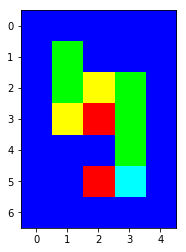

In [16]:
plt.imshow(snakes['X_test'][0], interpolation='nearest')